# 1. 라이브러리

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import lightgbm as lgbm
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

# 2. 데이터 전처리

## a. 파일 불러오기 및 데이터 확인

In [2]:
df_t = pd.read_csv("C:/Users/CPB06GameN/Downloads/titanic/train.csv")
df_t

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [3]:
df_t.shape

(891, 12)

In [4]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## b. 결측치 확인

In [5]:
df_t.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### - 성별과 클래스에 따른 나이의 분포를 확인하기 위한 데이터 형태로 재구성

#### 1. 나이와 생존여부의 상관관계를 확인하기 위해 데이터 프레임에서 나이와 생존여부 컬럼만 추출하고 병합

In [6]:
age_series = df_t.iloc[:,5]
age_series

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888     NaN
889    26.0
890    32.0
Name: Age, Length: 891, dtype: float64

In [7]:
survived_series = df_t.iloc[:,1]
survived_series

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [8]:
age_and_sur = pd.concat([age_series,survived_series],axis=1)
age_and_sur

,Age,Survived
0,22.0,0
1,38.0,1
2,26.0,1
3,35.0,1
4,35.0,0
...,...,...
886,27.0,0
887,19.0,1
888,NaN,0
889,26.0,1


#### 2. 두 데이터의 상관관계를 명확하게 보기 위해서 결측치를 삭제한 새로운 데이터프레임 생성

In [9]:
age_df_nan = age_and_sur.dropna()
age_df_nan

,Age,Survived
0,22.0,0
1,38.0,1
2,26.0,1
3,35.0,1
4,35.0,0
...,...,...
885,39.0,0
886,27.0,0
887,19.0,1
889,26.0,1


#### 3. 나이에 따른 생존여부를 커널밀도추정(kde) 그래프로 시각화

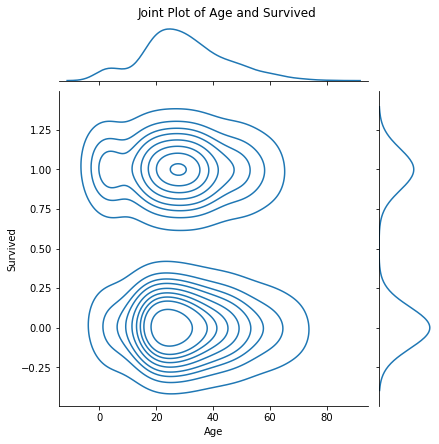

In [192]:
sns.jointplot(x="Age", y="Survived", data=age_df_nan, kind="kde")
plt.suptitle("Joint Plot of Age and Survived", y=1.02)
plt.show()

#### 4. 성별과 클래스를 각각 추출한 시리즈 생성 후 병합

In [10]:
gender_series = df_t.iloc[:,4]
gender_series

0        male
1      female
2      female
3      female
4        male
        ...  
886      male
887    female
888    female
889      male
890      male
Name: Sex, Length: 891, dtype: object

In [11]:
class_series = df_t.iloc[:,2]
class_series

0      3
1      1
2      3
3      1
4      3
      ..
886    2
887    1
888    3
889    1
890    3
Name: Pclass, Length: 891, dtype: int64

In [12]:
age_gen_cla = pd.concat([gender_series,class_series,age_series],axis=1)
age_gen_cla

,Sex,Pclass,Age
0,male,3,22.0
1,female,1,38.0
2,female,3,26.0
3,female,1,35.0
4,male,3,35.0
...,...,...,...
886,male,2,27.0
887,female,1,19.0
888,female,3,NaN
889,male,1,26.0


In [13]:
age_gen_cla_na = age_gen_cla.dropna()
age_gen_cla_na

,Sex,Pclass,Age
0,male,3,22.0
1,female,1,38.0
2,female,3,26.0
3,female,1,35.0
4,male,3,35.0
...,...,...,...
885,female,3,39.0
886,male,2,27.0
887,female,1,19.0
889,male,1,26.0


#### 5. 1등실 여성의 나이 데이터 필터링으로 추출

In [14]:
fem_fir = (age_gen_cla_na.Sex == "female") & (age_gen_cla_na.Pclass == 1)
fem_fir_df = age_gen_cla_na.loc[fem_fir,:]
fem_fir_df

,Sex,Pclass,Age
1,female,1,38.0
3,female,1,35.0
11,female,1,58.0
52,female,1,49.0
61,female,1,38.0
...,...,...,...
856,female,1,45.0
862,female,1,48.0
871,female,1,47.0
879,female,1,56.0


In [15]:
fem_fir_age = fem_fir_df.loc[:,fem_fir_df.columns.str.startswith('Age')]
fem_fir_age

,Age
1,38.0
3,35.0
11,58.0
52,49.0
61,38.0
...,...
856,45.0
862,48.0
871,47.0
879,56.0


#### 6. 1등실 남성의 나이 데이터 필터링으로 추출

In [16]:
mal_fir = (age_gen_cla_na.Sex == "male") & (age_gen_cla_na.Pclass == 1)
mal_fir_df = age_gen_cla_na.loc[mal_fir,:]
mal_fir_df

,Sex,Pclass,Age
6,male,1,54.0
23,male,1,28.0
27,male,1,19.0
30,male,1,40.0
34,male,1,28.0
...,...,...,...
822,male,1,38.0
857,male,1,51.0
867,male,1,31.0
872,male,1,33.0


In [17]:
mal_fir_age = mal_fir_df.loc[:,mal_fir_df.columns.str.startswith('Age')]
mal_fir_age

,Age
6,54.0
23,28.0
27,19.0
30,40.0
34,28.0
...,...
822,38.0
857,51.0
867,31.0
872,33.0


#### 7. 2등실 여성의 나이 데이터 필터링으로 추출

In [18]:
fem_sec = (age_gen_cla_na.Sex == "female") & (age_gen_cla_na.Pclass == 2)
fem_sec_df = age_gen_cla_na.loc[fem_sec,:]
fem_sec_df

,Sex,Pclass,Age
9,female,2,14.0
15,female,2,55.0
41,female,2,27.0
43,female,2,3.0
53,female,2,29.0
...,...,...,...
854,female,2,44.0
865,female,2,42.0
866,female,2,27.0
874,female,2,28.0


In [19]:
fem_sec_age = fem_sec_df.loc[:,fem_sec_df.columns.str.startswith('Age')]
fem_sec_age

,Age
9,14.0
15,55.0
41,27.0
43,3.0
53,29.0
...,...
854,44.0
865,42.0
866,27.0
874,28.0


#### 8. 2등실 남성의 나이 데이터 필터링으로 추출

In [20]:
mal_sec = (age_gen_cla_na.Sex == "male") & (age_gen_cla_na.Pclass == 2)
mal_sec_df = age_gen_cla_na.loc[mal_sec,:]
mal_sec_df

,Sex,Pclass,Age
20,male,2,35.0
21,male,2,34.0
33,male,2,66.0
70,male,2,32.0
72,male,2,21.0
...,...,...,...
848,male,2,28.0
861,male,2,21.0
864,male,2,24.0
883,male,2,28.0


In [21]:
mal_sec_age = mal_sec_df.loc[:,mal_sec_df.columns.str.startswith('Age')]
mal_sec_age

,Age
20,35.0
21,34.0
33,66.0
70,32.0
72,21.0
...,...
848,28.0
861,21.0
864,24.0
883,28.0


#### 10. 3등실 여성의 나이 데이터 필터링으로 추출

In [22]:
fem_thi = (age_gen_cla_na.Sex == "female") & (age_gen_cla_na.Pclass == 3)
fem_thi_df = age_gen_cla_na.loc[fem_thi,:]
fem_thi_df

,Sex,Pclass,Age
2,female,3,26.0
8,female,3,27.0
10,female,3,4.0
14,female,3,14.0
18,female,3,31.0
...,...,...,...
855,female,3,18.0
858,female,3,24.0
875,female,3,15.0
882,female,3,22.0


In [23]:
fem_thi_age = fem_thi_df.loc[:,fem_thi_df.columns.str.startswith('Age')]
fem_thi_age

,Age
2,26.0
8,27.0
10,4.0
14,14.0
18,31.0
...,...
855,18.0
858,24.0
875,15.0
882,22.0


#### 11. 3등실 남성의 나이 데이터 필터링으로 추출

In [24]:
mal_thi = (age_gen_cla_na.Sex == "male") & (age_gen_cla_na.Pclass == 3)
mal_thi_df = age_gen_cla_na.loc[mal_thi,:]
mal_thi_df

,Sex,Pclass,Age
0,male,3,22.0
4,male,3,35.0
7,male,3,2.0
12,male,3,20.0
13,male,3,39.0
...,...,...,...
876,male,3,20.0
877,male,3,19.0
881,male,3,33.0
884,male,3,25.0


In [25]:
mal_thi_age = mal_thi_df.loc[:,mal_thi_df.columns.str.startswith('Age')]
mal_thi_age

,Age
0,22.0
4,35.0
7,2.0
12,20.0
13,39.0
...,...
876,20.0
877,19.0
881,33.0
884,25.0


### - 성별과 클래스에 따른 각 나이별 데이터 개수

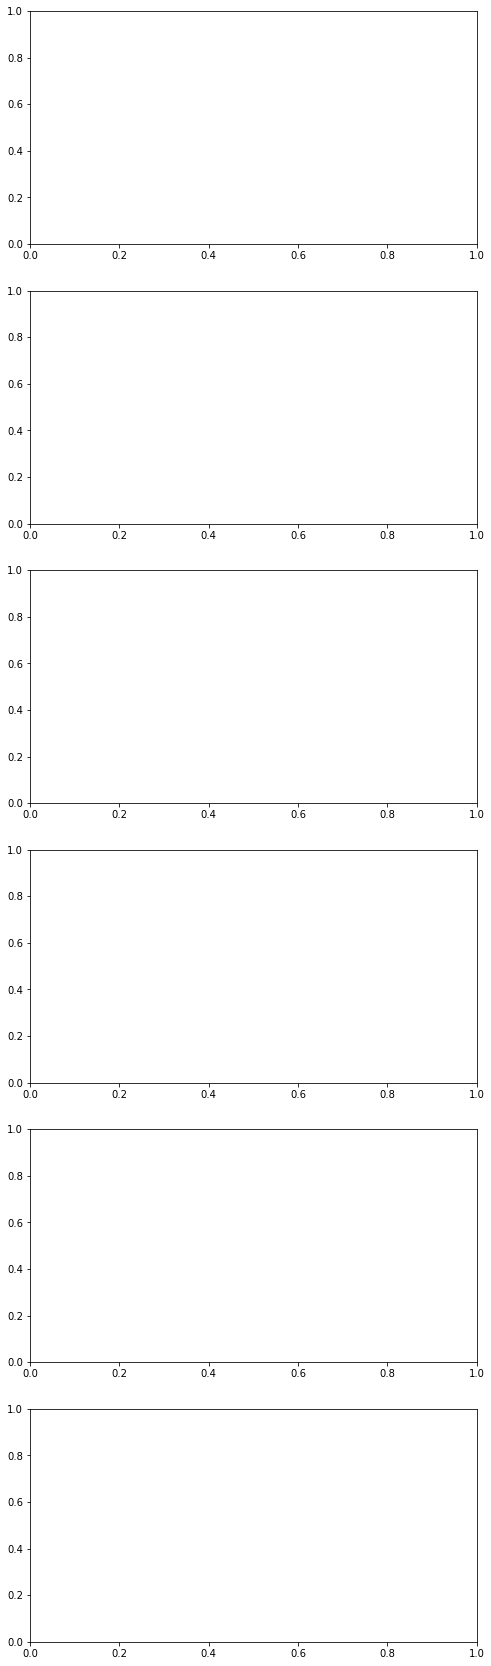

In [26]:
fig, axc = plt.subplots(nrows=6, ncols=1, figsize=(8,30))

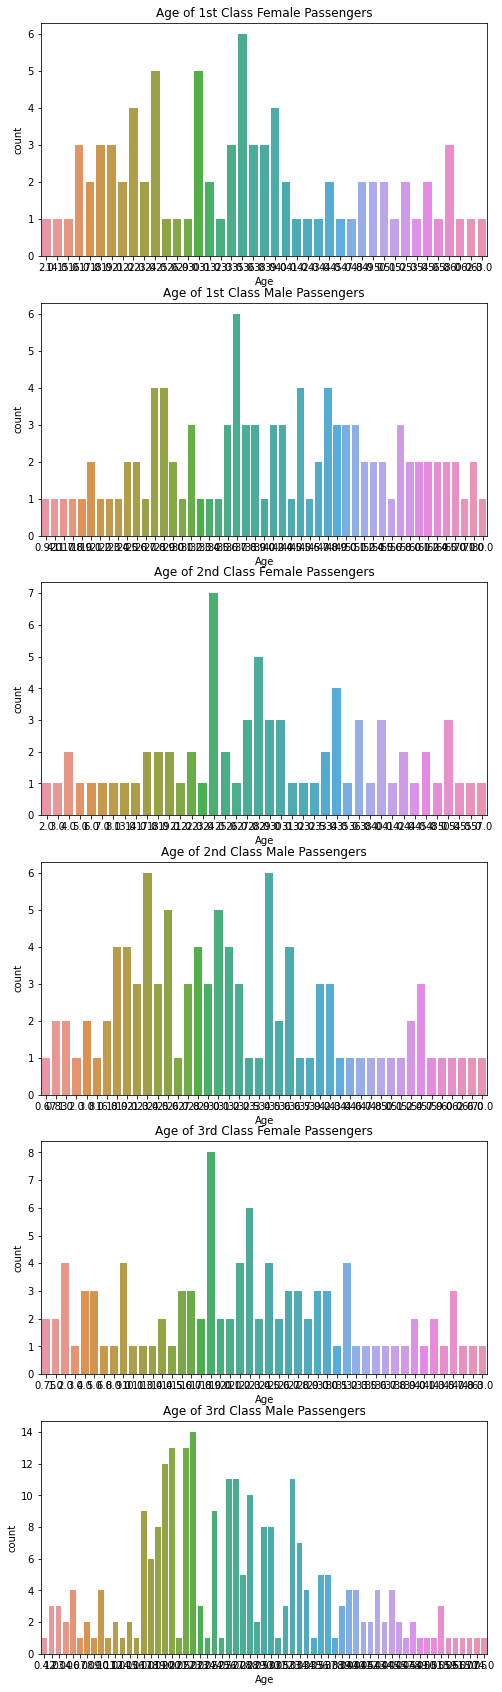

In [27]:
sns.countplot(x='Age', data=fem_fir_age, ax=axc[0])
axc[0].set_title("Age of 1st Class Female Passengers")

sns.countplot(x="Age", data=mal_fir_age, ax=axc[1])
axc[1].set_title("Age of 1st Class Male Passengers")

sns.countplot(x="Age", data=fem_sec_age, ax=axc[2])
axc[2].set_title("Age of 2nd Class Female Passengers")

sns.countplot(x="Age", data=mal_sec_age, ax=axc[3])
axc[3].set_title("Age of 2nd Class Male Passengers")

sns.countplot(x="Age", data=fem_thi_age, ax=axc[4])
axc[4].set_title("Age of 3rd Class Female Passengers")

sns.countplot(x="Age", data=mal_thi_age, ax=axc[5])
axc[5].set_title("Age of 3rd Class Male Passengers")

fig

### - 성별과 클래스에 따른 나이 분포 시각화

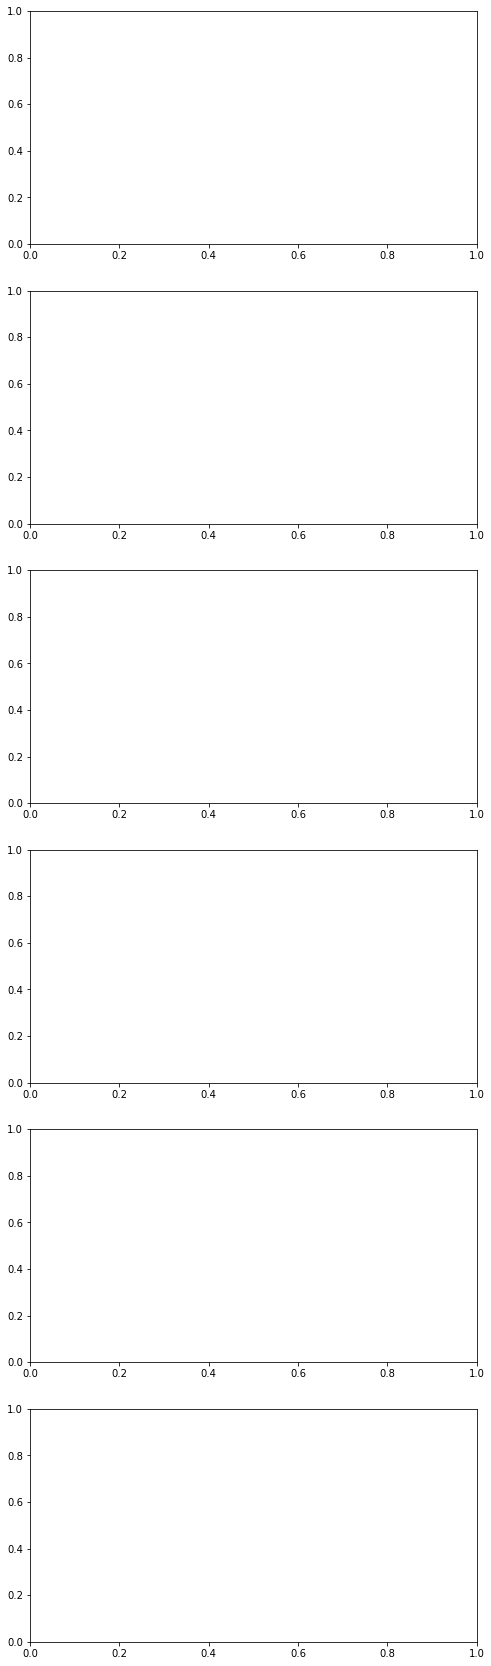

In [28]:
fig, axk = plt.subplots(nrows=6, ncols=1, figsize=(8,30))

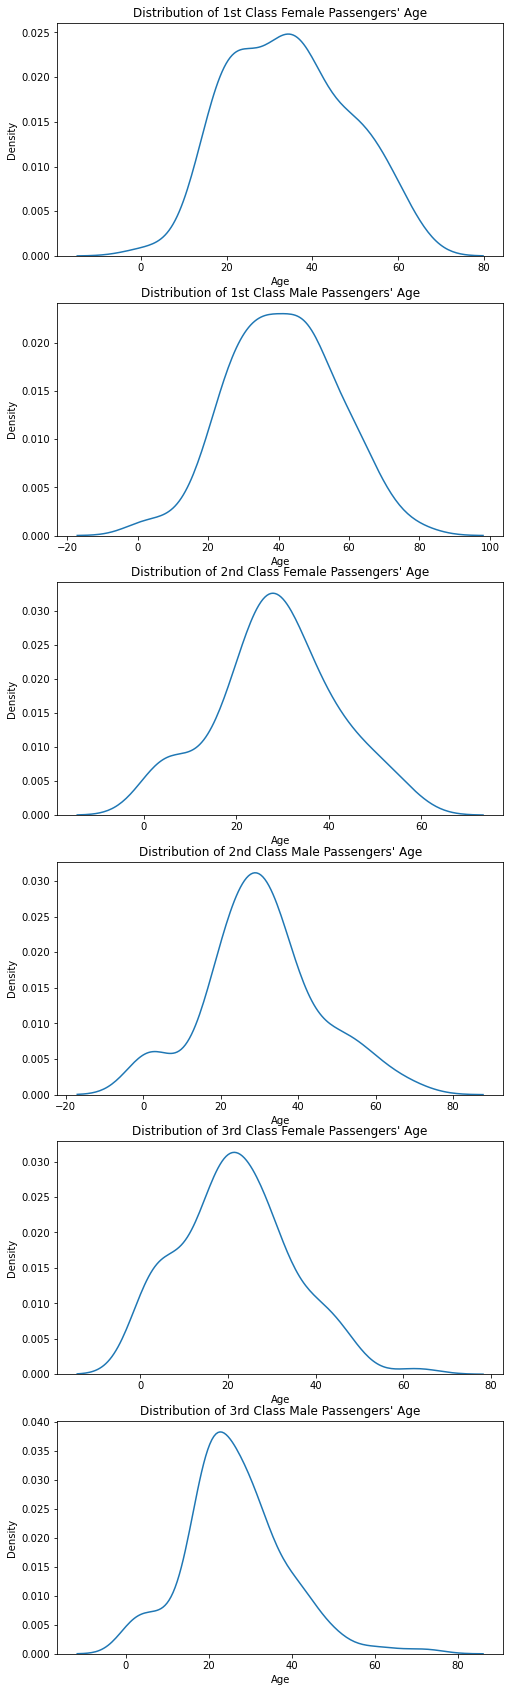

In [29]:
sns.kdeplot(fem_fir_df["Age"], ax=axk[0])
axk[0].set_title("Distribution of 1st Class Female Passengers' Age")

sns.kdeplot(mal_fir_df["Age"], ax=axk[1])
axk[1].set_title("Distribution of 1st Class Male Passengers' Age")

sns.kdeplot(fem_sec_df["Age"], ax=axk[2])
axk[2].set_title("Distribution of 2nd Class Female Passengers' Age")

sns.kdeplot(mal_sec_df["Age"], ax=axk[3])
axk[3].set_title("Distribution of 2nd Class Male Passengers' Age")

sns.kdeplot(fem_thi_df["Age"], ax=axk[4])
axk[4].set_title("Distribution of 3rd Class Female Passengers' Age")

sns.kdeplot(mal_thi_df["Age"], ax=axk[5])
axk[5].set_title("Distribution of 3rd Class Male Passengers' Age")

fig

### - 각 항목의 상관관계 그래프 (성별로 색깔 구분)

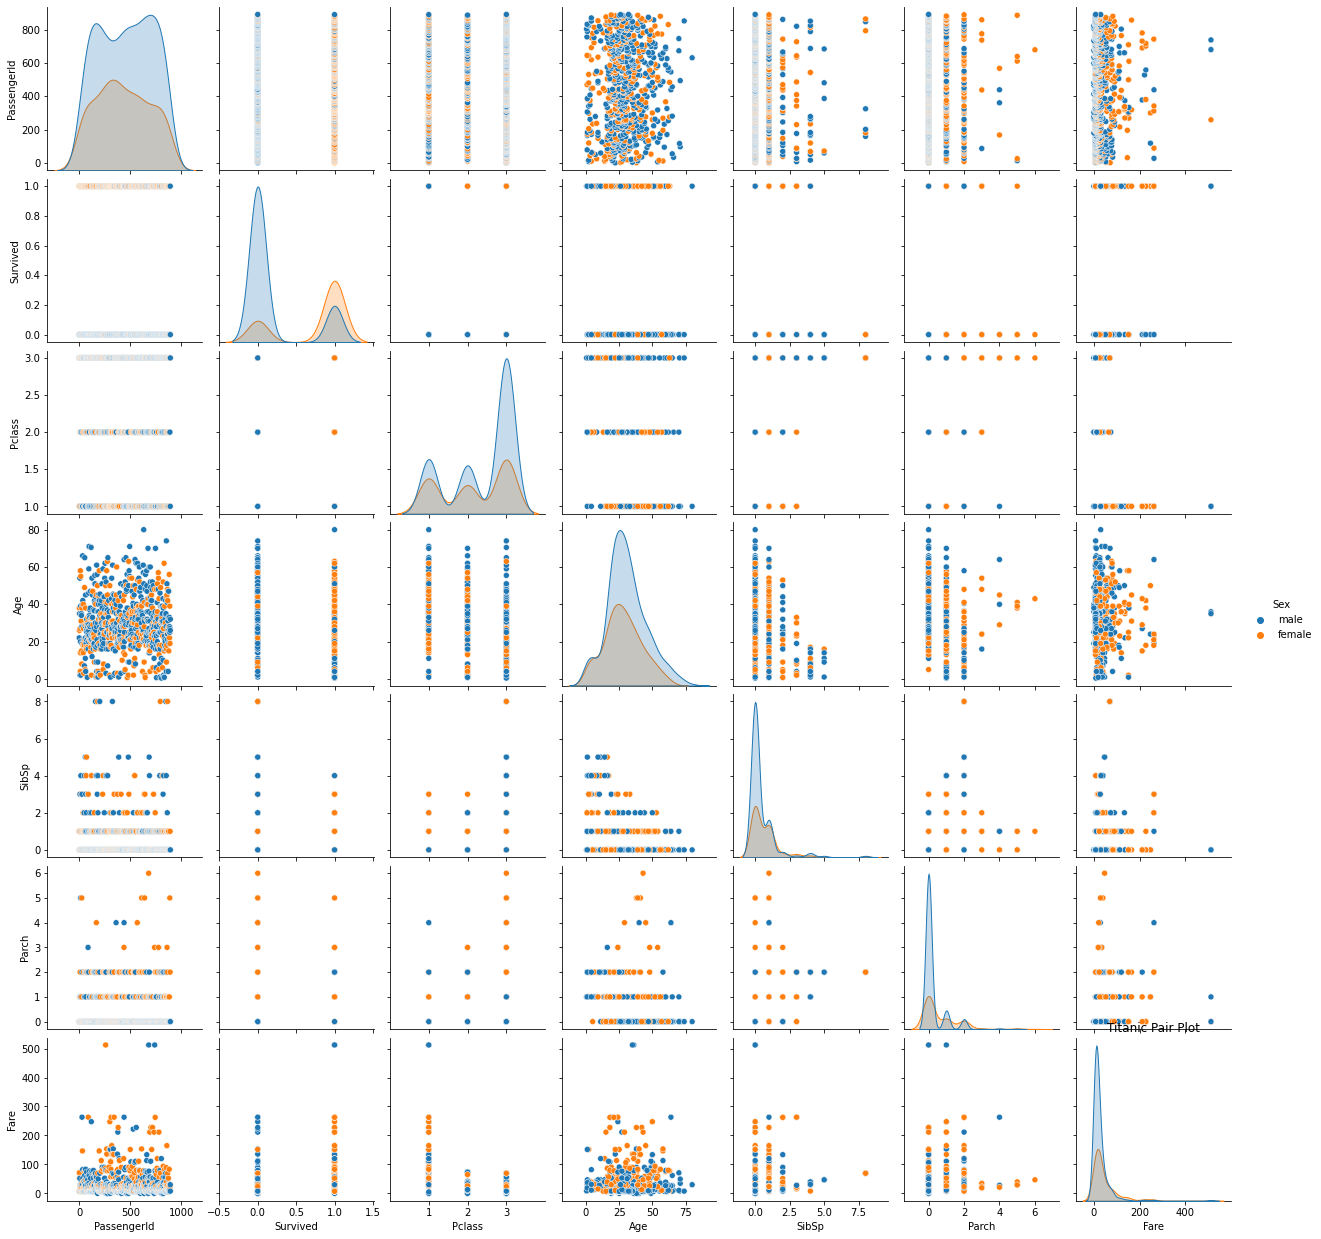

In [30]:
sns.pairplot(df_t, hue="Sex")
plt.title("Titanic Pair Plot")
plt.show()

### - 각 항목의 상관관계 그래프 (클래스로 색깔 구분)

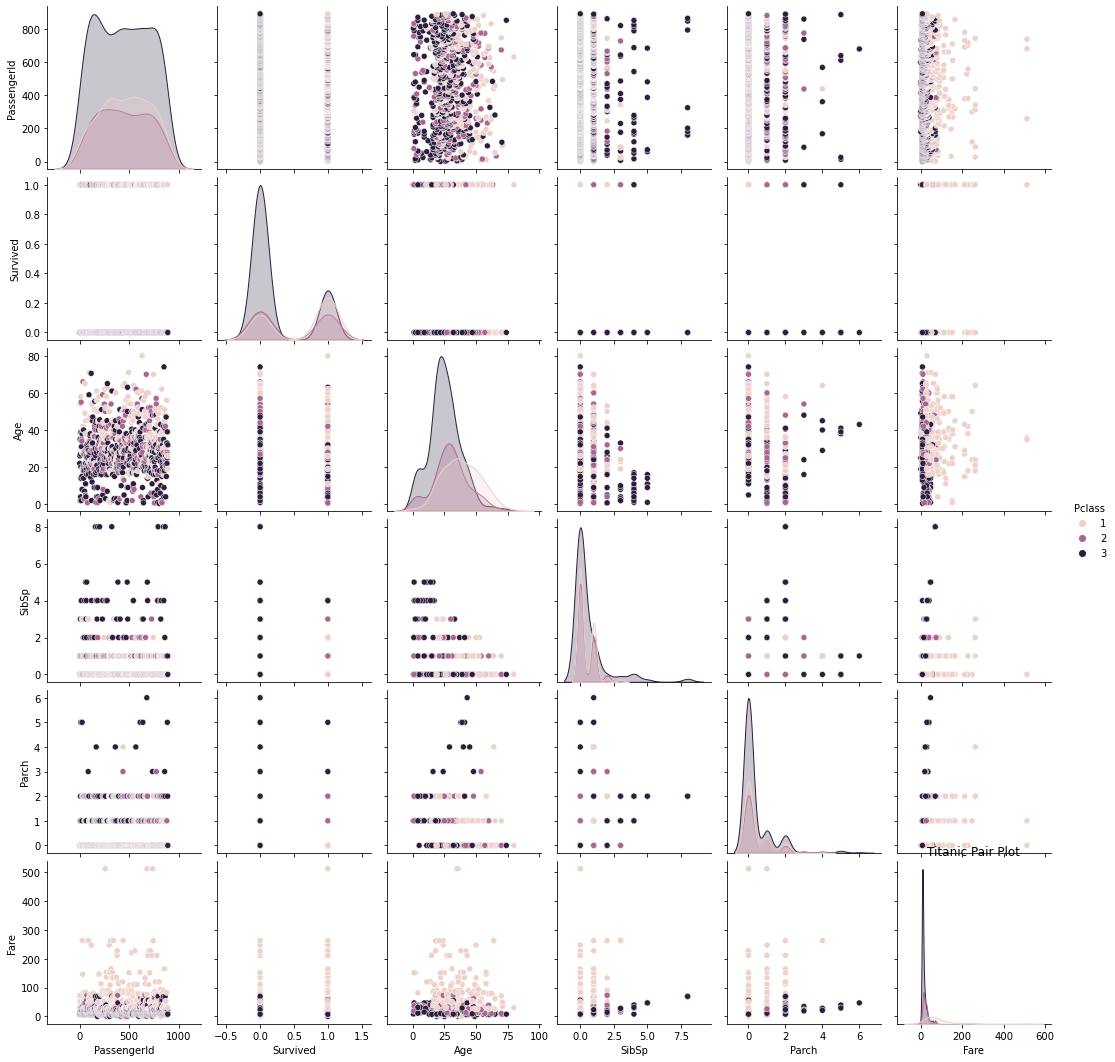

In [31]:
sns.pairplot(df_t, hue="Pclass")
plt.title("Titanic Pair Plot")
plt.show()

## c. 결측치 처리를 위한 데이터 재구성

### - train 데이터와 test 데이터의 결측치를 같이 처리

#### 1. train 데이터와 test 데이터를 합친 파일 불러오기

In [32]:
df = pd.read_csv("C:/Users/CPB06GameN/Downloads/titanic/train_and_test.csv")
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [33]:
df.shape

(1309, 12)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [35]:
df_for_null = df[['Name','Pclass','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']]
df_for_null

,Name,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,"Braund, Mr. Owen Harris",3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,"Heikkinen, Miss. Laina",3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,female,35.0,1,0,113803,53.1000,C123,S
4,"Allen, Mr. William Henry",3,male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...
1304,"Spector, Mr. Woolf",3,male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,"Oliva y Ocana, Dona. Fermina",1,female,39.0,0,0,PC 17758,108.9000,C105,C
1306,"Saether, Mr. Simon Sivertsen",3,male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,"Ware, Mr. Frederick",3,male,NaN,0,0,359309,8.0500,NaN,S


### - Fare 결측치 처리

In [36]:
df_fare = df_for_null[['Name','Pclass','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']]
df_fare

,Name,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,"Braund, Mr. Owen Harris",3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,"Heikkinen, Miss. Laina",3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,female,35.0,1,0,113803,53.1000,C123,S
4,"Allen, Mr. William Henry",3,male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...
1304,"Spector, Mr. Woolf",3,male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,"Oliva y Ocana, Dona. Fermina",1,female,39.0,0,0,PC 17758,108.9000,C105,C
1306,"Saether, Mr. Simon Sivertsen",3,male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,"Ware, Mr. Frederick",3,male,NaN,0,0,359309,8.0500,NaN,S


#### 1. KNeighbors로 결측치 예측한 값으로 대체

In [37]:
# get_dummies로 인코딩
df_fare_dummy = pd.get_dummies(data=df_fare,columns=['Name','Pclass','Sex','Age','SibSp','Parch','Ticket','Cabin','Embarked'])
knn_f =KNeighborsRegressor()
knn_f.fit(df_fare_dummy[df_fare_dummy['Fare'].isnull()==False][df_fare_dummy.columns.drop('Fare')], df_fare_dummy[df_fare_dummy['Fare'].isnull()==False]['Fare'])
fare_guess = knn_f.predict(df_fare_dummy[df_fare_dummy['Fare'].isnull()==True][df_fare_dummy.columns.drop('Fare')])
fare_guess

array([9.40416])

### - Embarked 결측치 처리

In [38]:
df_embarked = df_for_null[['Name','Pclass','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']]
le_e = LabelEncoder()
df_embarked["Embarked"] = le_e.fit_transform(df_embarked["Embarked"])
df_embarked["Embarked"] = df_embarked["Embarked"].replace(3,np.NaN)
df_embarked

,Name,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,"Braund, Mr. Owen Harris",3,male,22.0,1,0,A/5 21171,7.2500,NaN,2.0
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,female,38.0,1,0,PC 17599,71.2833,C85,0.0
2,"Heikkinen, Miss. Laina",3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,2.0
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,female,35.0,1,0,113803,53.1000,C123,2.0
4,"Allen, Mr. William Henry",3,male,35.0,0,0,373450,8.0500,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...
1304,"Spector, Mr. Woolf",3,male,NaN,0,0,A.5. 3236,8.0500,NaN,2.0
1305,"Oliva y Ocana, Dona. Fermina",1,female,39.0,0,0,PC 17758,108.9000,C105,0.0
1306,"Saether, Mr. Simon Sivertsen",3,male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,2.0
1307,"Ware, Mr. Frederick",3,male,NaN,0,0,359309,8.0500,NaN,2.0


#### 1. KNeighbors로 결측치 예측한 값으로 대체

In [39]:
# get_dummies로 인코딩
df_embarked_dummy = pd.get_dummies(data=df_embarked,columns=['Name','Pclass','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin'])
knn_e =KNeighborsRegressor()
knn_e.fit(df_embarked_dummy[df_embarked_dummy['Embarked'].isnull()==False][df_embarked_dummy.columns.drop('Embarked')], df_embarked_dummy[df_embarked_dummy['Embarked'].isnull()==False]['Embarked'])
embarked_guess = knn_e.predict(df_embarked_dummy[df_embarked_dummy['Embarked'].isnull()==True][df_embarked_dummy.columns.drop('Embarked')])
embarked_guess

array([0.4, 0.4])

### - Fare, Embarked 결측치 대체

In [40]:
df["Fare"] = df["Fare"].replace(np.NaN,9.40416)

In [ ]:
df["Embarked"] = df["Embarked"].replace(np.NaN,'C')

### - 머신러닝을 활용하기 편하게 데이터 인코딩

#### 1. Cabin 데이터에서 Deck 값만 추출

In [42]:
df["Deck"] = df["Cabin"].str[:1]
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,NaN
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,NaN
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,NaN
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,NaN
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,NaN


#### 2. 티켓 데이터에서 숫자만 추출

In [43]:
df["TicketNo"] = df["Ticket"].str.split(" ").str[-1]
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,TicketNo
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,NaN,21171
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,17599
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,NaN,3101282
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,113803
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,NaN,373450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,NaN,3236
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,C,17758
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,NaN,3101262
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,NaN,359309


#### 3. 성별, 탑승항구, 데크 레이블인코딩

In [44]:
le_1 = LabelEncoder()
df["Gender"] = le_1.fit_transform(df["Sex"])

le_2 = LabelEncoder()
df["EmbarkedNo"] = le_2.fit_transform(df["Embarked"])

le_3 = LabelEncoder()
df["DeckNo"] = le_3.fit_transform(df["Deck"])

df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,TicketNo,Gender,EmbarkedNo,DeckNo
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,NaN,21171,1,2,8
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,17599,0,0,2
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,NaN,3101282,0,2,8
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,113803,0,2,2
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,NaN,373450,1,2,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,NaN,3236,1,2,8
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,C,17758,0,0,2
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,NaN,3101262,1,2,8
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,NaN,359309,1,2,8


In [45]:
le_1.classes_, le_2.classes_, le_3.classes_

(array(['female', 'male'], dtype=object),
 array(['C', 'Q', 'S'], dtype=object),
 array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', nan], dtype=object))

### - 나이 예측 모델 생성

In [46]:
df_use = df[['PassengerId','Gender','Pclass','SibSp','Parch','Fare','TicketNo','DeckNo','EmbarkedNo','Age']]
df_use

,PassengerId,Gender,Pclass,SibSp,Parch,Fare,TicketNo,DeckNo,EmbarkedNo,Age
0,1,1,3,1,0,7.2500,21171,8,2,22.0
1,2,0,1,1,0,71.2833,17599,2,0,38.0
2,3,0,3,0,0,7.9250,3101282,8,2,26.0
3,4,0,1,1,0,53.1000,113803,2,2,35.0
4,5,1,3,0,0,8.0500,373450,8,2,35.0
...,...,...,...,...,...,...,...,...,...,...
1304,1305,1,3,0,0,8.0500,3236,8,2,NaN
1305,1306,0,1,0,0,108.9000,17758,2,0,39.0
1306,1307,1,3,0,0,7.2500,3101262,8,2,38.5
1307,1308,1,3,0,0,8.0500,359309,8,2,NaN


In [47]:
df_use.shape

(1309, 10)

In [48]:
df_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Gender       1309 non-null   int32  
 2   Pclass       1309 non-null   int64  
 3   SibSp        1309 non-null   int64  
 4   Parch        1309 non-null   int64  
 5   Fare         1309 non-null   float64
 6   TicketNo     1309 non-null   object 
 7   DeckNo       1309 non-null   int32  
 8   EmbarkedNo   1309 non-null   int32  
 9   Age          1046 non-null   float64
dtypes: float64(2), int32(3), int64(4), object(1)
memory usage: 87.1+ KB


#### 1. 모든 항목의 데이터 타입을 정수 혹은 실수로 전환

In [49]:
df_use['TicketNo'] = df_use["TicketNo"].replace(['LINE'],['0'])
df_use['TicketNo'] = pd.to_numeric(df_use['TicketNo'])
df_use

,PassengerId,Gender,Pclass,SibSp,Parch,Fare,TicketNo,DeckNo,EmbarkedNo,Age
0,1,1,3,1,0,7.2500,21171,8,2,22.0
1,2,0,1,1,0,71.2833,17599,2,0,38.0
2,3,0,3,0,0,7.9250,3101282,8,2,26.0
3,4,0,1,1,0,53.1000,113803,2,2,35.0
4,5,1,3,0,0,8.0500,373450,8,2,35.0
...,...,...,...,...,...,...,...,...,...,...
1304,1305,1,3,0,0,8.0500,3236,8,2,NaN
1305,1306,0,1,0,0,108.9000,17758,2,0,39.0
1306,1307,1,3,0,0,7.2500,3101262,8,2,38.5
1307,1308,1,3,0,0,8.0500,359309,8,2,NaN


In [50]:
df_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Gender       1309 non-null   int32  
 2   Pclass       1309 non-null   int64  
 3   SibSp        1309 non-null   int64  
 4   Parch        1309 non-null   int64  
 5   Fare         1309 non-null   float64
 6   TicketNo     1309 non-null   int64  
 7   DeckNo       1309 non-null   int32  
 8   EmbarkedNo   1309 non-null   int32  
 9   Age          1046 non-null   float64
dtypes: float64(2), int32(3), int64(5)
memory usage: 87.1 KB


In [51]:
df_train = df_use.iloc[:891,:]
df_test = df_use.iloc[891:,:]

In [52]:
df_train

,PassengerId,Gender,Pclass,SibSp,Parch,Fare,TicketNo,DeckNo,EmbarkedNo,Age
0,1,1,3,1,0,7.2500,21171,8,2,22.0
1,2,0,1,1,0,71.2833,17599,2,0,38.0
2,3,0,3,0,0,7.9250,3101282,8,2,26.0
3,4,0,1,1,0,53.1000,113803,2,2,35.0
4,5,1,3,0,0,8.0500,373450,8,2,35.0
...,...,...,...,...,...,...,...,...,...,...
886,887,1,2,0,0,13.0000,211536,8,2,27.0
887,888,0,1,0,0,30.0000,112053,1,2,19.0
888,889,0,3,1,2,23.4500,6607,8,2,NaN
889,890,1,1,0,0,30.0000,111369,2,0,26.0


In [53]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Gender       891 non-null    int32  
 2   Pclass       891 non-null    int64  
 3   SibSp        891 non-null    int64  
 4   Parch        891 non-null    int64  
 5   Fare         891 non-null    float64
 6   TicketNo     891 non-null    int64  
 7   DeckNo       891 non-null    int32  
 8   EmbarkedNo   891 non-null    int32  
 9   Age          714 non-null    float64
dtypes: float64(2), int32(3), int64(5)
memory usage: 59.3 KB


In [54]:
df_test

,PassengerId,Gender,Pclass,SibSp,Parch,Fare,TicketNo,DeckNo,EmbarkedNo,Age
891,892,1,3,0,0,7.8292,330911,8,1,34.5
892,893,0,3,1,0,7.0000,363272,8,2,47.0
893,894,1,2,0,0,9.6875,240276,8,1,62.0
894,895,1,3,0,0,8.6625,315154,8,2,27.0
895,896,0,3,1,1,12.2875,3101298,8,2,22.0
...,...,...,...,...,...,...,...,...,...,...
1304,1305,1,3,0,0,8.0500,3236,8,2,NaN
1305,1306,0,1,0,0,108.9000,17758,2,0,39.0
1306,1307,1,3,0,0,7.2500,3101262,8,2,38.5
1307,1308,1,3,0,0,8.0500,359309,8,2,NaN


In [55]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 891 to 1308
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Gender       418 non-null    int32  
 2   Pclass       418 non-null    int64  
 3   SibSp        418 non-null    int64  
 4   Parch        418 non-null    int64  
 5   Fare         418 non-null    float64
 6   TicketNo     418 non-null    int64  
 7   DeckNo       418 non-null    int32  
 8   EmbarkedNo   418 non-null    int32  
 9   Age          332 non-null    float64
dtypes: float64(2), int32(3), int64(5)
memory usage: 27.9 KB


#### 2. 나이 결측치 예측 및 대체

In [56]:
# knn.fit(df_use[df_use["Age"].isnull()==False][df_use.columns.drop("Age")], df_use[df_use["Age"].isnull()==False]["Age"])
# age_guess = knn.predict(df_use[df_use["Age"].isnull()==True][df_use.columns.drop("Age")])
# 전체(train과 test를 합친) 데이터로 학습시키려고 했지만 에러가 떠서 train과 test로 나누어서 진행

knn = KNeighborsRegressor()
knn.fit(df_train[df_train["Age"].isnull()==False][df_train.columns.drop("Age")], df_train[df_train["Age"].isnull()==False]["Age"])
age_guess_train = knn.predict(df_train[df_train["Age"].isnull()==True][df_train.columns.drop("Age")])
age_guess_train

array([30.4  , 35.8  , 21.   , 21.5  , 30.4  , 29.   , 35.8  , 31.2  ,
       21.   , 29.   , 44.6  , 36.7  , 29.4  , 21.   , 30.   , 35.8  ,
       21.   , 29.   , 39.7  , 30.4  , 22.2  , 39.7  , 29.   , 25.8  ,
       39.1  , 26.7  , 36.7  , 18.3  , 19.1  , 23.4  , 21.8  , 22.4  ,
       42.8  , 33.6  , 32.6  , 22.4  , 17.8  , 26.4  , 36.7  , 37.2  ,
       36.7  , 26.   , 26.7  , 27.8  , 32.6  , 19.2  , 33.1  , 26.7  ,
       30.2  , 49.4  , 10.   , 10.   , 26.6  , 36.7  , 29.2  , 34.1  ,
       43.8  , 37.8  , 20.   , 26.7  , 29.6  , 26.1  , 39.8  , 20.2  ,
       26.7  , 40.2  , 25.6  , 10.   , 35.2  , 20.9  , 30.4  , 30.4  ,
       36.7  , 17.2  , 29.6  , 45.6  , 26.6  , 22.3  , 33.4  , 26.6  ,
       22.2  , 29.2  , 24.9  , 26.4  , 31.6  , 31.5  , 31.4  , 26.7  ,
       26.7  , 14.75 , 32.4  , 37.3  , 14.75 , 29.2  , 35.6  , 15.8  ,
       30.6  , 29.2  , 33.4  , 26.7  ,  9.15 , 34.4  , 30.4  , 37.4  ,
       26.4  , 37.3  , 14.35 , 14.35 , 38.8  , 14.35 , 14.35 , 29.7  ,
      

In [57]:
df_train.loc[df_train["Age"].isnull()==True,"Age"] = age_guess_train

In [58]:
age_guess_test = knn.predict(df_test[df_test["Age"].isnull()==True][df_test.columns.drop("Age")])
age_guess_test

array([28.8, 38. , 19.5, 30.8, 24.9, 23.4, 25.8, 36.7, 22.5, 17.4, 38.6,
       25.2, 28.8, 29.2, 19.5, 23.8, 34. , 33.4, 21.3, 17.4, 30.4, 30.4,
       19.5, 24.8, 30.7, 24.8, 38.6, 19.5, 32.2, 25.8, 28.8, 31.2, 24.9,
       36. , 35.6, 19.5, 24.8, 15.6, 33.6, 26.7, 46. , 41.4, 17.6, 30.4,
       23.6, 19.5, 36.7, 30.4, 30.4, 30.8, 19.5, 23. , 22.5, 28.8, 31.8,
       26.7, 27.8, 29.5, 36.7, 19.5, 23.2, 17.6, 19.5, 23.4, 36. , 19.5,
       19.5, 36. , 17.4, 23.4, 19.5, 19.5, 12.4, 42.8, 43.4, 29.5, 12.4,
       19.5, 24.8, 29. , 15.6, 31.2, 26.4, 27.6, 25.2, 19.5])

In [59]:
df_test.loc[df_test["Age"].isnull()==True,"Age"] = age_guess_test

In [60]:
df_train.isnull().sum()

PassengerId    0
Gender         0
Pclass         0
SibSp          0
Parch          0
Fare           0
TicketNo       0
DeckNo         0
EmbarkedNo     0
Age            0
dtype: int64

In [61]:
df_test.isnull().sum()

PassengerId    0
Gender         0
Pclass         0
SibSp          0
Parch          0
Fare           0
TicketNo       0
DeckNo         0
EmbarkedNo     0
Age            0
dtype: int64

In [62]:
age_guess_train.shape, age_guess_test.shape

((177,), (86,))

In [63]:
df_train

,PassengerId,Gender,Pclass,SibSp,Parch,Fare,TicketNo,DeckNo,EmbarkedNo,Age
0,1,1,3,1,0,7.2500,21171,8,2,22.0
1,2,0,1,1,0,71.2833,17599,2,0,38.0
2,3,0,3,0,0,7.9250,3101282,8,2,26.0
3,4,0,1,1,0,53.1000,113803,2,2,35.0
4,5,1,3,0,0,8.0500,373450,8,2,35.0
...,...,...,...,...,...,...,...,...,...,...
886,887,1,2,0,0,13.0000,211536,8,2,27.0
887,888,0,1,0,0,30.0000,112053,1,2,19.0
888,889,0,3,1,2,23.4500,6607,8,2,30.8
889,890,1,1,0,0,30.0000,111369,2,0,26.0


In [64]:
df_test

,PassengerId,Gender,Pclass,SibSp,Parch,Fare,TicketNo,DeckNo,EmbarkedNo,Age
891,892,1,3,0,0,7.8292,330911,8,1,34.5
892,893,0,3,1,0,7.0000,363272,8,2,47.0
893,894,1,2,0,0,9.6875,240276,8,1,62.0
894,895,1,3,0,0,8.6625,315154,8,2,27.0
895,896,0,3,1,1,12.2875,3101298,8,2,22.0
...,...,...,...,...,...,...,...,...,...,...
1304,1305,1,3,0,0,8.0500,3236,8,2,27.6
1305,1306,0,1,0,0,108.9000,17758,2,0,39.0
1306,1307,1,3,0,0,7.2500,3101262,8,2,38.5
1307,1308,1,3,0,0,8.0500,359309,8,2,25.2


In [65]:
df_full = pd.concat([df_train, df_test], axis = 0)
df_full

,PassengerId,Gender,Pclass,SibSp,Parch,Fare,TicketNo,DeckNo,EmbarkedNo,Age
0,1,1,3,1,0,7.2500,21171,8,2,22.0
1,2,0,1,1,0,71.2833,17599,2,0,38.0
2,3,0,3,0,0,7.9250,3101282,8,2,26.0
3,4,0,1,1,0,53.1000,113803,2,2,35.0
4,5,1,3,0,0,8.0500,373450,8,2,35.0
...,...,...,...,...,...,...,...,...,...,...
1304,1305,1,3,0,0,8.0500,3236,8,2,27.6
1305,1306,0,1,0,0,108.9000,17758,2,0,39.0
1306,1307,1,3,0,0,7.2500,3101262,8,2,38.5
1307,1308,1,3,0,0,8.0500,359309,8,2,25.2


### - Deck 결측치 대체

In [66]:
df_full["DeckNo"] = df_full["DeckNo"].replace(8,np.NaN)

In [67]:
knn = KNeighborsRegressor()
knn.fit(df_full[df_full["DeckNo"].isnull()==False][df_full.columns.drop("DeckNo")], df_full[df_full["DeckNo"].isnull()==False]["DeckNo"])
deck_guess = knn.predict(df_full[df_full["DeckNo"].isnull()==True][df_full.columns.drop("DeckNo")])
deck_guess = np.around(deck_guess)
deck_guess

array([2., 4., 4., ..., 4., 5., 4.])

In [68]:
df_full.loc[df_full["DeckNo"].isnull()==True,"DeckNo"] = deck_guess

### - 결측치 처리 완료한 데이터로 파일 생성

In [69]:
train_ready = df_full.iloc[:891,:]
test_ready = df_full.iloc[891:,:]

In [70]:
train_ready

,PassengerId,Gender,Pclass,SibSp,Parch,Fare,TicketNo,DeckNo,EmbarkedNo,Age
0,1,1,3,1,0,7.2500,21171,2.0,2,22.0
1,2,0,1,1,0,71.2833,17599,2.0,0,38.0
2,3,0,3,0,0,7.9250,3101282,4.0,2,26.0
3,4,0,1,1,0,53.1000,113803,2.0,2,35.0
4,5,1,3,0,0,8.0500,373450,4.0,2,35.0
...,...,...,...,...,...,...,...,...,...,...
886,887,1,2,0,0,13.0000,211536,5.0,2,27.0
887,888,0,1,0,0,30.0000,112053,1.0,2,19.0
888,889,0,3,1,2,23.4500,6607,3.0,2,30.8
889,890,1,1,0,0,30.0000,111369,2.0,0,26.0


In [71]:
test_ready

,PassengerId,Gender,Pclass,SibSp,Parch,Fare,TicketNo,DeckNo,EmbarkedNo,Age
891,892,1,3,0,0,7.8292,330911,5.0,1,34.5
892,893,0,3,1,0,7.0000,363272,5.0,2,47.0
893,894,1,2,0,0,9.6875,240276,4.0,1,62.0
894,895,1,3,0,0,8.6625,315154,5.0,2,27.0
895,896,0,3,1,1,12.2875,3101298,4.0,2,22.0
...,...,...,...,...,...,...,...,...,...,...
1304,1305,1,3,0,0,8.0500,3236,4.0,2,27.6
1305,1306,0,1,0,0,108.9000,17758,2.0,0,39.0
1306,1307,1,3,0,0,7.2500,3101262,4.0,2,38.5
1307,1308,1,3,0,0,8.0500,359309,5.0,2,25.2


In [72]:
# train_ready.to_csv("C:/Users/CPB06GameN/Downloads/DataFrame/train_ready.csv")

In [73]:
# test_ready.to_csv("C:/Users/CPB06GameN/Downloads/DataFrame/test_ready.csv")

# 3. 결측치 완료 데이터 활용

## a. 기존 train 데이터와 같은 형태로 재구성하기 위해 Survived 컬럼 추가

In [74]:
train = pd.read_csv("C:/Users/CPB06GameN/Downloads/DataFrame/train_ready.csv")
train

,Unnamed: 0,PassengerId,Gender,Pclass,SibSp,Parch,Fare,TicketNo,DeckNo,EmbarkedNo,Age
0,0,1,1,3,1,0,7.2500,21171,2.0,2,22.0
1,1,2,0,1,1,0,71.2833,17599,2.0,0,38.0
2,2,3,0,3,0,0,7.9250,3101282,4.0,2,26.0
3,3,4,0,1,1,0,53.1000,113803,2.0,2,35.0
4,4,5,1,3,0,0,8.0500,373450,4.0,2,35.0
...,...,...,...,...,...,...,...,...,...,...,...
886,886,887,1,2,0,0,13.0000,211536,5.0,2,27.0
887,887,888,0,1,0,0,30.0000,112053,1.0,2,19.0
888,888,889,0,3,1,2,23.4500,6607,3.0,2,30.8
889,889,890,1,1,0,0,30.0000,111369,2.0,0,26.0


In [75]:
train = train.drop(['Unnamed: 0', 'PassengerId'], axis=1)

In [76]:
train.shape

(891, 9)

In [77]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Gender      891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   SibSp       891 non-null    int64  
 3   Parch       891 non-null    int64  
 4   Fare        891 non-null    float64
 5   TicketNo    891 non-null    int64  
 6   DeckNo      891 non-null    float64
 7   EmbarkedNo  891 non-null    int64  
 8   Age         891 non-null    float64
dtypes: float64(3), int64(6)
memory usage: 62.8 KB


In [78]:
column_survived = df_t[['Survived']]
column_survived

,Survived
0,0
1,1
2,1
3,1
4,0
...,...
886,0
887,1
888,0
889,1


In [79]:
train = pd.concat([train,column_survived], axis=1)
train

,Gender,Pclass,SibSp,Parch,Fare,TicketNo,DeckNo,EmbarkedNo,Age,Survived
0,1,3,1,0,7.2500,21171,2.0,2,22.0,0
1,0,1,1,0,71.2833,17599,2.0,0,38.0,1
2,0,3,0,0,7.9250,3101282,4.0,2,26.0,1
3,0,1,1,0,53.1000,113803,2.0,2,35.0,1
4,1,3,0,0,8.0500,373450,4.0,2,35.0,0
...,...,...,...,...,...,...,...,...,...,...
886,1,2,0,0,13.0000,211536,5.0,2,27.0,0
887,0,1,0,0,30.0000,112053,1.0,2,19.0,1
888,0,3,1,2,23.4500,6607,3.0,2,30.8,0
889,1,1,0,0,30.0000,111369,2.0,0,26.0,1


In [80]:
train.shape

(891, 10)

In [81]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Gender      891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   SibSp       891 non-null    int64  
 3   Parch       891 non-null    int64  
 4   Fare        891 non-null    float64
 5   TicketNo    891 non-null    int64  
 6   DeckNo      891 non-null    float64
 7   EmbarkedNo  891 non-null    int64  
 8   Age         891 non-null    float64
 9   Survived    891 non-null    int64  
dtypes: float64(3), int64(7)
memory usage: 69.7 KB


In [82]:
test = pd.read_csv("C:/Users/CPB06GameN/Downloads/DataFrame/test_ready.csv")
test

,Unnamed: 0,PassengerId,Gender,Pclass,SibSp,Parch,Fare,TicketNo,DeckNo,EmbarkedNo,Age
0,891,892,1,3,0,0,7.8292,330911,5.0,1,34.5
1,892,893,0,3,1,0,7.0000,363272,5.0,2,47.0
2,893,894,1,2,0,0,9.6875,240276,4.0,1,62.0
3,894,895,1,3,0,0,8.6625,315154,5.0,2,27.0
4,895,896,0,3,1,1,12.2875,3101298,4.0,2,22.0
...,...,...,...,...,...,...,...,...,...,...,...
413,1304,1305,1,3,0,0,8.0500,3236,4.0,2,27.6
414,1305,1306,0,1,0,0,108.9000,17758,2.0,0,39.0
415,1306,1307,1,3,0,0,7.2500,3101262,4.0,2,38.5
416,1307,1308,1,3,0,0,8.0500,359309,5.0,2,25.2


In [83]:
test = test.drop(['Unnamed: 0', 'PassengerId'], axis=1)

In [84]:
# train.to_csv("C:/Users/CPB06GameN/Downloads/DataFrame/train_data.csv")

In [85]:
# test.to_csv("C:/Users/CPB06GameN/Downloads/DataFrame/test_data.csv")

## b. 데이터 분석

In [86]:
train_stat = train[["Gender", "Pclass", "SibSp", "Parch", "Fare", "TicketNo", "DeckNo", "EmbarkedNo", "Age", "Survived"]]
train_stat

,Gender,Pclass,SibSp,Parch,Fare,TicketNo,DeckNo,EmbarkedNo,Age,Survived
0,1,3,1,0,7.2500,21171,2.0,2,22.0,0
1,0,1,1,0,71.2833,17599,2.0,0,38.0,1
2,0,3,0,0,7.9250,3101282,4.0,2,26.0,1
3,0,1,1,0,53.1000,113803,2.0,2,35.0,1
4,1,3,0,0,8.0500,373450,4.0,2,35.0,0
...,...,...,...,...,...,...,...,...,...,...
886,1,2,0,0,13.0000,211536,5.0,2,27.0,0
887,0,1,0,0,30.0000,112053,1.0,2,19.0,1
888,0,3,1,2,23.4500,6607,3.0,2,30.8,0
889,1,1,0,0,30.0000,111369,2.0,0,26.0,1


In [87]:
train_stat.rename(columns = {"DeckNo" : "Deck"}, inplace = True)
train_stat.rename(columns = {"EmbarkedNo" : "Embarked"}, inplace = True)
train_stat

,Gender,Pclass,SibSp,Parch,Fare,TicketNo,Deck,Embarked,Age,Survived
0,1,3,1,0,7.2500,21171,2.0,2,22.0,0
1,0,1,1,0,71.2833,17599,2.0,0,38.0,1
2,0,3,0,0,7.9250,3101282,4.0,2,26.0,1
3,0,1,1,0,53.1000,113803,2.0,2,35.0,1
4,1,3,0,0,8.0500,373450,4.0,2,35.0,0
...,...,...,...,...,...,...,...,...,...,...
886,1,2,0,0,13.0000,211536,5.0,2,27.0,0
887,0,1,0,0,30.0000,112053,1.0,2,19.0,1
888,0,3,1,2,23.4500,6607,3.0,2,30.8,0
889,1,1,0,0,30.0000,111369,2.0,0,26.0,1


In [88]:
train_stat["Gender"] = train_stat["Gender"].replace(0,'female')
train_stat["Gender"] = train_stat["Gender"].replace(1,'male')
train_stat["Deck"] = train_stat["Deck"].replace(0,'A')
train_stat["Deck"] = train_stat["Deck"].replace(1,'B')
train_stat["Deck"] = train_stat["Deck"].replace(2,'C')
train_stat["Deck"] = train_stat["Deck"].replace(3,'D')
train_stat["Deck"] = train_stat["Deck"].replace(4,'E')
train_stat["Deck"] = train_stat["Deck"].replace(5,'F')
train_stat["Deck"] = train_stat["Deck"].replace(6,'G')
train_stat["Deck"] = train_stat["Deck"].replace(7,'T')
train_stat["Embarked"] = train_stat["Embarked"].replace(0,'C')
train_stat["Embarked"] = train_stat["Embarked"].replace(1,'Q')
train_stat["Embarked"] = train_stat["Embarked"].replace(2,'S')

# array(['female', 'male'], dtype=object),
# array(['C', 'Q', 'S'], dtype=object),
# array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', nan], dtype=object)

In [89]:
train_stat

,Gender,Pclass,SibSp,Parch,Fare,TicketNo,Deck,Embarked,Age,Survived
0,male,3,1,0,7.2500,21171,C,S,22.0,0
1,female,1,1,0,71.2833,17599,C,C,38.0,1
2,female,3,0,0,7.9250,3101282,E,S,26.0,1
3,female,1,1,0,53.1000,113803,C,S,35.0,1
4,male,3,0,0,8.0500,373450,E,S,35.0,0
...,...,...,...,...,...,...,...,...,...,...
886,male,2,0,0,13.0000,211536,F,S,27.0,0
887,female,1,0,0,30.0000,112053,B,S,19.0,1
888,female,3,1,2,23.4500,6607,D,S,30.8,0
889,male,1,0,0,30.0000,111369,C,C,26.0,1


### - 연령대 컬럼 추가

In [90]:
def age(x):
    if 0<=x<=12: return '0-12'
    elif 12<x<=22: return '13-22'
    elif 22<x<=32: return '23-32'
    elif 32<x<=42: return '33-42'
    elif 42<x<=52: return '43-52'
    elif 52<x<=65: return '52-65'
    else: return 'over65'

train_stat["Age"] = train_stat["Age"].apply(age)

### - Fare 데이터를 보기 편하게 범위로 변환

In [91]:
train_stat["Fare"].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [92]:
farenp = train_stat[["Fare"]].to_numpy()

In [93]:
farenp

array([[  7.25  ],
       [ 71.2833],
       [  7.925 ],
       [ 53.1   ],
       [  8.05  ],
       [  8.4583],
       [ 51.8625],
       [ 21.075 ],
       [ 11.1333],
       [ 30.0708],
       [ 16.7   ],
       [ 26.55  ],
       [  8.05  ],
       [ 31.275 ],
       [  7.8542],
       [ 16.    ],
       [ 29.125 ],
       [ 13.    ],
       [ 18.    ],
       [  7.225 ],
       [ 26.    ],
       [ 13.    ],
       [  8.0292],
       [ 35.5   ],
       [ 21.075 ],
       [ 31.3875],
       [  7.225 ],
       [263.    ],
       [  7.8792],
       [  7.8958],
       [ 27.7208],
       [146.5208],
       [  7.75  ],
       [ 10.5   ],
       [ 82.1708],
       [ 52.    ],
       [  7.2292],
       [  8.05  ],
       [ 18.    ],
       [ 11.2417],
       [  9.475 ],
       [ 21.    ],
       [  7.8958],
       [ 41.5792],
       [  7.8792],
       [  8.05  ],
       [ 15.5   ],
       [  7.75  ],
       [ 21.6792],
       [ 17.8   ],
       [ 39.6875],
       [  7.8   ],
       [ 76.

In [94]:
train_stat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Gender    891 non-null    object 
 1   Pclass    891 non-null    int64  
 2   SibSp     891 non-null    int64  
 3   Parch     891 non-null    int64  
 4   Fare      891 non-null    float64
 5   TicketNo  891 non-null    int64  
 6   Deck      891 non-null    object 
 7   Embarked  891 non-null    object 
 8   Age       891 non-null    object 
 9   Survived  891 non-null    int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 69.7+ KB


#### 1. 백분위로 범위 나누기

In [95]:
f1, f2, f3, f4, f5, f6, f7, f8, f9, f10 = np.percentile(farenp, [10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
f1, f2, f3, f4, f5, f6, f7, f8, f9, f10

(7.55, 7.8542, 8.05, 10.5, 14.4542, 21.6792, 27.0, 39.6875, 77.9583, 512.3292)

In [96]:
def fare(x):
    if x<=7.5: return '0<=f<=7.5'
    elif 7.5<x<=7.9: return '7.5<f<=7.9'
    elif 7.9<x<=8.1: return '7.9<f<=8.1'
    elif 8.1<x<=10.5: return '8.1<f<=10.5'
    elif 10.5<x<=14.5: return '10.5<f<=14.5'
    elif 14.5<x<=21.7: return '14.5<f<=21.7'
    elif 21.7<x<=27.0: return '21.7<f<=27.0'
    elif 27.0<x<=39.7: return '27.0<f<=39.7'
    elif 39.7<x<=78.0: return '39.7<f<=78.0'
    else: return 'over78.0'

train_stat["Fare"] = train_stat["Fare"].apply(fare)

In [97]:
train_stat

,Gender,Pclass,SibSp,Parch,Fare,TicketNo,Deck,Embarked,Age,Survived
0,male,3,1,0,0<=f<=7.5,21171,C,S,13-22,0
1,female,1,1,0,39.7<f<=78.0,17599,C,C,33-42,1
2,female,3,0,0,7.9<f<=8.1,3101282,E,S,23-32,1
3,female,1,1,0,39.7<f<=78.0,113803,C,S,33-42,1
4,male,3,0,0,7.9<f<=8.1,373450,E,S,33-42,0
...,...,...,...,...,...,...,...,...,...,...
886,male,2,0,0,10.5<f<=14.5,211536,F,S,23-32,0
887,female,1,0,0,27.0<f<=39.7,112053,B,S,13-22,1
888,female,3,1,2,21.7<f<=27.0,6607,D,S,23-32,0
889,male,1,0,0,27.0<f<=39.7,111369,C,C,23-32,1


## c. 각 항목별 생존율

In [98]:
train_stat[["Gender", "Survived"]].groupby(["Gender"], as_index=False).mean().sort_values(by="Survived", ascending=False)

,Gender,Survived
0,female,0.742038
1,male,0.188908


In [99]:
train_stat[["Pclass", "Survived"]].groupby(["Pclass"], as_index=False).mean().sort_values(by="Survived", ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [100]:
train_stat[["SibSp", "Survived"]].groupby(["SibSp"], as_index=False).mean().sort_values(by="Survived", ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [101]:
train_stat[["Parch", "Survived"]].groupby(["Parch"], as_index=False).mean().sort_values(by="Survived", ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


In [102]:
train_stat[["Fare", "Survived"]].groupby(["Fare"], as_index=False).mean().sort_values(by="Survived", ascending=False)

,Fare,Survived
9,over78.0,0.758621
5,39.7<f<=78.0,0.528090
3,21.7<f<=27.0,0.516854
2,14.5<f<=21.7,0.448718
1,10.5<f<=14.5,0.404255
4,27.0<f<=39.7,0.373626
6,7.5<f<=7.9,0.235294
8,8.1<f<=10.5,0.230769
7,7.9<f<=8.1,0.225806
0,0<=f<=7.5,0.137931


In [103]:
train_stat[["TicketNo", "Survived"]].groupby(["TicketNo"], as_index=False).mean().sort_values(by="Survived", ascending=False)

,TicketNo,Survived
129,11752,1.0
328,113505,1.0
153,13567,1.0
154,13568,1.0
156,14258,1.0
...,...,...
294,48871,0.0
293,45380,0.0
292,39886,0.0
289,36967,0.0


In [104]:
train_stat[["Deck", "Survived"]].groupby(["Deck"], as_index=False).mean().sort_values(by="Survived", ascending=False)

,Deck,Survived
1,B,0.642857
2,C,0.500000
6,G,0.500000
0,A,0.466667
3,D,0.408451
4,E,0.366548
5,F,0.269231
7,T,0.000000


In [105]:
train_stat[["Embarked", "Survived"]].groupby(["Embarked"], as_index=False).mean().sort_values(by="Survived", ascending=False)

,Embarked,Survived
0,C,0.558824
1,Q,0.389610
2,S,0.336957


In [106]:
train_stat[["Age", "Survived"]].groupby(["Age"], as_index=False).mean().sort_values(by="Survived", ascending=False)

,Age,Survived
0,0-12,0.561644
3,33-42,0.406417
4,43-52,0.397727
5,52-65,0.372093
2,23-32,0.366438
1,13-22,0.330000
6,over65,0.125000


# 4. 모델 생성

## a. 머신러닝 활용 데이터 불러오기

In [107]:
train = pd.read_csv("C:/Users/CPB06GameN/Downloads/DataFrame/train_data.csv")
train

,Unnamed: 0,Gender,Pclass,SibSp,Parch,Fare,TicketNo,DeckNo,EmbarkedNo,Age,Survived
0,0,1,3,1,0,7.2500,21171,2.0,2,22.0,0
1,1,0,1,1,0,71.2833,17599,2.0,0,38.0,1
2,2,0,3,0,0,7.9250,3101282,4.0,2,26.0,1
3,3,0,1,1,0,53.1000,113803,2.0,2,35.0,1
4,4,1,3,0,0,8.0500,373450,4.0,2,35.0,0
...,...,...,...,...,...,...,...,...,...,...,...
886,886,1,2,0,0,13.0000,211536,5.0,2,27.0,0
887,887,0,1,0,0,30.0000,112053,1.0,2,19.0,1
888,888,0,3,1,2,23.4500,6607,3.0,2,30.8,0
889,889,1,1,0,0,30.0000,111369,2.0,0,26.0,1


In [108]:
train = train.drop(['Unnamed: 0'], axis=1)

In [109]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Gender      891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   SibSp       891 non-null    int64  
 3   Parch       891 non-null    int64  
 4   Fare        891 non-null    float64
 5   TicketNo    891 non-null    int64  
 6   DeckNo      891 non-null    float64
 7   EmbarkedNo  891 non-null    int64  
 8   Age         891 non-null    float64
 9   Survived    891 non-null    int64  
dtypes: float64(3), int64(7)
memory usage: 69.7 KB


In [110]:
test = pd.read_csv("C:/Users/CPB06GameN/Downloads/DataFrame/test_data.csv")
test

,Unnamed: 0,Gender,Pclass,SibSp,Parch,Fare,TicketNo,DeckNo,EmbarkedNo,Age
0,0,1,3,0,0,7.8292,330911,5.0,1,34.5
1,1,0,3,1,0,7.0000,363272,5.0,2,47.0
2,2,1,2,0,0,9.6875,240276,4.0,1,62.0
3,3,1,3,0,0,8.6625,315154,5.0,2,27.0
4,4,0,3,1,1,12.2875,3101298,4.0,2,22.0
...,...,...,...,...,...,...,...,...,...,...
413,413,1,3,0,0,8.0500,3236,4.0,2,27.6
414,414,0,1,0,0,108.9000,17758,2.0,0,39.0
415,415,1,3,0,0,7.2500,3101262,4.0,2,38.5
416,416,1,3,0,0,8.0500,359309,5.0,2,25.2


In [111]:
test = test.drop(['Unnamed: 0'], axis=1)

In [112]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Gender      418 non-null    int64  
 1   Pclass      418 non-null    int64  
 2   SibSp       418 non-null    int64  
 3   Parch       418 non-null    int64  
 4   Fare        418 non-null    float64
 5   TicketNo    418 non-null    int64  
 6   DeckNo      418 non-null    float64
 7   EmbarkedNo  418 non-null    int64  
 8   Age         418 non-null    float64
dtypes: float64(3), int64(6)
memory usage: 29.5 KB


## b. train과 test 데이터 지정하기

In [113]:
X_train = train.iloc[:,:-1].values
y_train = train.Survived.values
X_train.shape, y_train.shape

((891, 9), (891,))

In [114]:
X_test = test.iloc[:,:].values
X_test.shape

(418, 9)

## c. 모델 테스트

### 1. Support Vector Machine (기본 변수)

In [115]:
svc = SVC(random_state=2022)

In [116]:
svc.fit(X_train, y_train)

SVC(random_state=2022)

In [117]:
prediction = svc.predict(X_test)

In [118]:
Submission_svc = pd.DataFrame({'Survived': prediction})
Submission_svc.to_csv("C:/Users/CPB06GameN/Downloads/DataFrame/submission_svc.csv")

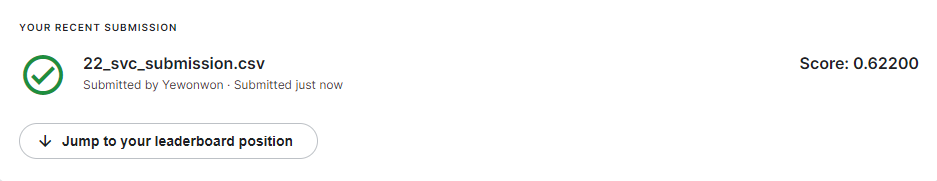

### 2. Support Vector Machine (Sigmoid)

In [119]:
svc_s = SVC(kernel='sigmoid', gamma=3, random_state=2022)

In [120]:
svc_s.fit(X_train, y_train)

SVC(gamma=3, kernel='sigmoid', random_state=2022)

In [121]:
prediction = svc_s.predict(X_test)

In [122]:
Submission_svc_sig = pd.DataFrame({'Survived': prediction})
Submission_svc_sig.to_csv("C:/Users/CPB06GameN/Downloads/DataFrame/submission_svc_sig.csv")

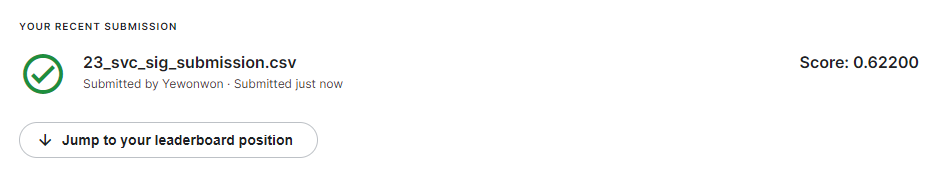

### 3. Random Forest (기본 변수)

In [123]:
rfc = RandomForestClassifier(random_state=2022)
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 2022,
 'verbose': 0,
 'warm_start': False}

In [124]:
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=2022)

In [125]:
prediction = rfc.predict(X_test)

In [126]:
Submission = pd.DataFrame({'Survived': prediction})
Submission.to_csv("C:/Users/CPB06GameN/Downloads/DataFrame/submission.csv")

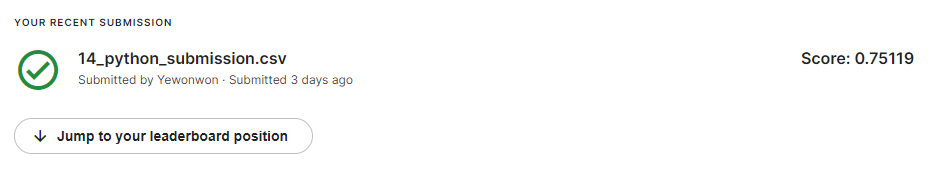

### 4. Random Forest (최적의 파라메터 적용)

In [127]:
params = {
    'max_depth': [3,4,5,6,7],
    'min_samples_split': [2,3,4]
}

In [128]:
grid_rf = GridSearchCV(rfc, param_grid=params, scoring='accuracy', cv=3)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=2022),
             param_grid={'max_depth': [3, 4, 5, 6, 7],
                         'min_samples_split': [2, 3, 4]},
             scoring='accuracy')

In [129]:
grid_rf.best_params_

{'max_depth': 7, 'min_samples_split': 2}

In [130]:
params = {
    'max_depth': [6,7,8,9,10],
    'min_samples_split': [3,4,5,6]
}

In [131]:
grid_rf = GridSearchCV(rfc, param_grid=params, scoring='accuracy', cv=3)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=2022),
             param_grid={'max_depth': [6, 7, 8, 9, 10],
                         'min_samples_split': [3, 4, 5, 6]},
             scoring='accuracy')

In [132]:
grid_rf.best_params_

{'max_depth': 8, 'min_samples_split': 3}

In [133]:
rfc_max = RandomForestClassifier(random_state=2022, max_depth=7)
rfc_max.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 7,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 2022,
 'verbose': 0,
 'warm_start': False}

In [134]:
rfc_max.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, random_state=2022)

In [135]:
prediction = rfc_max.predict(X_test)

In [177]:
Submission_rfc_max = pd.DataFrame({'Survived': prediction})
Submission_rfc_max.to_csv("C:/Users/CPB06GameN/Downloads/DataFrame/submission_rfc_max_update.csv")

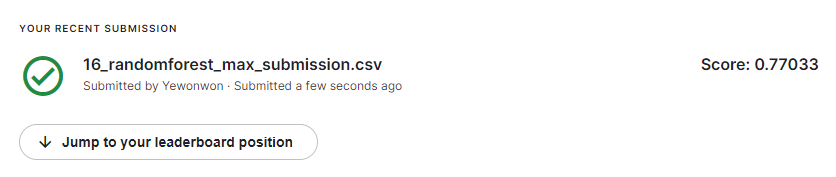

### 5. Decision Tree (기본)

In [137]:
dtc = DecisionTreeClassifier(random_state=2022)
dtc.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 2022,
 'splitter': 'best'}

In [138]:
dtc.fit(X_train, y_train)

DecisionTreeClassifier(random_state=2022)

In [139]:
prediction = dtc.predict(X_test)

In [140]:
Submission_dtc = pd.DataFrame({'Survived': prediction})
Submission_dtc.to_csv("C:/Users/CPB06GameN/Downloads/DataFrame/submission_dtc.csv")

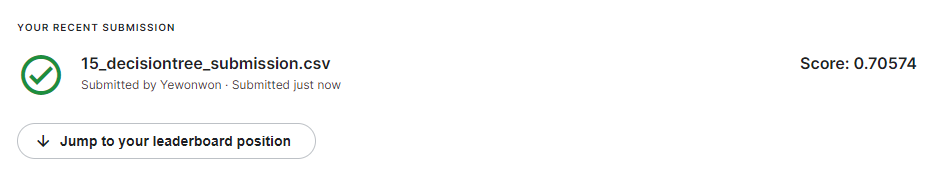

### 6. Decision Tree (최적의 파라메터 적용)

In [141]:
params = {
    'max_depth': [3,4,5,6,7],
    'min_samples_split': [2,3,4]
}

In [142]:
grid_dt = GridSearchCV(dtc, param_grid=params, scoring='accuracy', cv=3)
grid_dt.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=2022),
             param_grid={'max_depth': [3, 4, 5, 6, 7],
                         'min_samples_split': [2, 3, 4]},
             scoring='accuracy')

In [143]:
grid_dt.best_params_

{'max_depth': 5, 'min_samples_split': 2}

In [144]:
params = {
    'max_depth': [5,6,7,8],
    'min_samples_split': [5,6,7,8]
}

In [145]:
grid_dt = GridSearchCV(dtc, param_grid=params, scoring='accuracy', cv=3)
grid_dt.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=2022),
             param_grid={'max_depth': [5, 6, 7, 8],
                         'min_samples_split': [5, 6, 7, 8]},
             scoring='accuracy')

In [146]:
grid_dt.best_params_

{'max_depth': 5, 'min_samples_split': 6}

In [178]:
dtc_max = DecisionTreeClassifier(random_state=2022, max_depth=5, min_samples_split=6)
dtc_max.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 2022,
 'splitter': 'best'}

In [179]:
dtc_max.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_split=6, random_state=2022)

In [180]:
prediction = dtc_max.predict(X_test)

In [181]:
Submission_dtc_max = pd.DataFrame({'Survived': prediction})
Submission_dtc_max.to_csv("C:/Users/CPB06GameN/Downloads/DataFrame/submission_dtc_max_update.csv")

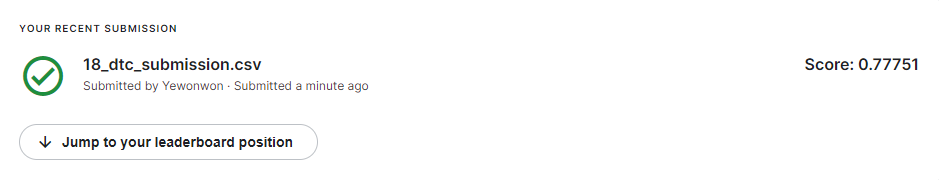

### 7. XGradient Boost (기본)

In [151]:
xgbc = xgb.XGBClassifier(random_state=2022)
xgbc.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'enable_categorical': False,
 'gamma': None,
 'gpu_id': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 2022,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [152]:
xgbc.fit(X_train, y_train)

[13:51:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=2022,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [153]:
prediction = xgbc.predict(X_test)

In [154]:
Submission_xgbc = pd.DataFrame({'Survived': prediction})
Submission_xgbc.to_csv("C:/Users/CPB06GameN/Downloads/DataFrame/submission_xgbc.csv")

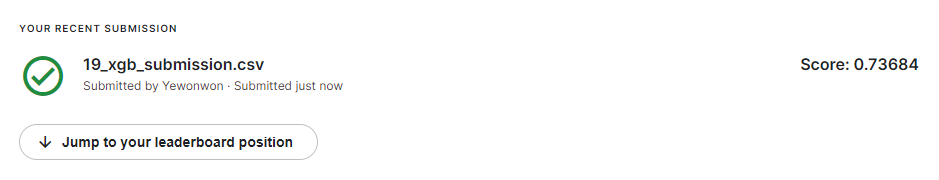

### 8. XGradient Boost (최적의 파라메터 적용)

In [155]:
params = {
    'max_depth': [3,4,5,6,7],
    'learning_rate': [0.1,1.0,10]
}

In [156]:
grid_xgb = GridSearchCV(estimator = XGBClassifier(n_estimators=100),param_grid=params, scoring='accuracy', cv=3)
grid_xgb.fit(X_train, y_train)
grid_xgb.best_params_

[13:51:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:51:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:51:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:51:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:51:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:51:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:51:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:51:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

{'learning_rate': 0.1, 'max_depth': 4}

In [157]:
params = {
    'max_depth': [3,4,5,6,7],
    'learning_rate': [0.01, 0.1, 0.3]
}

In [158]:
grid_xgb = GridSearchCV(estimator = XGBClassifier(n_estimators=100),param_grid=params, scoring='accuracy', cv=3)
grid_xgb.fit(X_train, y_train)
grid_xgb.best_params_

[13:52:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:52:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:52:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:52:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:52:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:52:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:52:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:52:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

{'learning_rate': 0.1, 'max_depth': 4}

In [182]:
xgbc_params = xgb.XGBClassifier(learning_rate=0.1, max_depth=4, n_estimators=100, random_state=2022)

In [183]:
xgbc_params.fit(X_train, y_train)

[13:54:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=2022,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [184]:
prediction = xgbc_params.predict(X_test)

In [185]:
Submission_xgbc_max = pd.DataFrame({'Survived': prediction})
Submission_xgbc_max.to_csv("C:/Users/CPB06GameN/Downloads/DataFrame/submission_xgbc_max_update.csv")

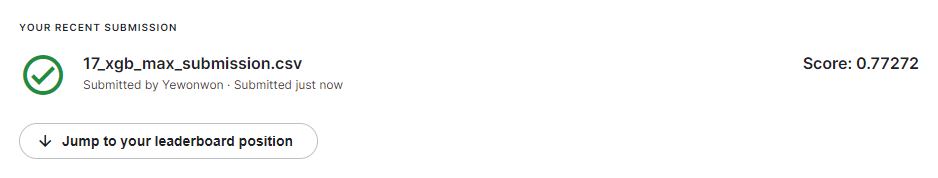

### 9. Light Gradient Boost (기본)

In [163]:
lgbm = LGBMClassifier(random_state=2022)
lgbm.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 2022,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [164]:
lgbm.fit(X_train, y_train)

LGBMClassifier(random_state=2022)

In [165]:
prediction = lgbm.predict(X_test)

In [166]:
Submission_lgbm = pd.DataFrame({'Survived': prediction})
Submission_lgbm.to_csv("C:/Users/CPB06GameN/Downloads/DataFrame/submission_lgbm.csv")

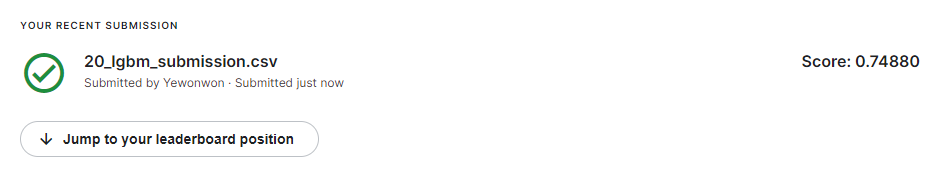

### 10. Light Gradient Boost (최적의 파라메터 적용)

In [167]:
params = {'max_depth': [3,4,5,6,7],
         'min_child_samples': [10, 20, 30]}

In [168]:
grid_lgbm = GridSearchCV(estimator = LGBMClassifier(n_estimators=100),param_grid=params, scoring='accuracy', cv=3)
grid_lgbm.fit(X_train, y_train)
grid_lgbm.best_params_

{'max_depth': 4, 'min_child_samples': 10}

In [169]:
params = {'max_depth': [3,4,5],
         'min_child_samples': [30, 40, 50]}

In [170]:
grid_lgbm = GridSearchCV(estimator = LGBMClassifier(n_estimators=100),param_grid=params, scoring='accuracy', cv=3)
grid_lgbm.fit(X_train, y_train)
grid_lgbm.best_params_

{'max_depth': 3, 'min_child_samples': 40}

In [171]:
params = {'max_depth': [3,4,5],
         'min_child_samples': [50,60,70],
         'min_child_weight': [0.001, 0.01, 0.1]}

In [172]:
grid_lgbm = GridSearchCV(estimator = LGBMClassifier(n_estimators=100),param_grid=params, scoring='accuracy', cv=3)
grid_lgbm.fit(X_train, y_train)
grid_lgbm.best_params_

{'max_depth': 4, 'min_child_samples': 70, 'min_child_weight': 0.001}

In [186]:
params = {'max_depth': [3,4,5,6],
         'min_child_samples': [50,60,70,80],
         'min_child_weight': [0.001, 0.01, 0.1]}

In [187]:
grid_lgbm = GridSearchCV(estimator = LGBMClassifier(n_estimators=100),param_grid=params, scoring='accuracy', cv=3)
grid_lgbm.fit(X_train, y_train)
grid_lgbm.best_params_

{'max_depth': 4, 'min_child_samples': 70, 'min_child_weight': 0.001}

In [188]:
lgbm_params = LGBMClassifier(random_state=2022, max_depth=4, min_child_samples=70 )

In [189]:
lgbm_params.fit(X_train, y_train)

LGBMClassifier(max_depth=4, min_child_samples=70, random_state=2022)

In [190]:
prediction = lgbm_params.predict(X_test)

In [191]:
Submission_lgbm_max = pd.DataFrame({'Survived': prediction})
Submission_lgbm_max.to_csv("C:/Users/CPB06GameN/Downloads/DataFrame/submission_lgbm_max_update.csv")

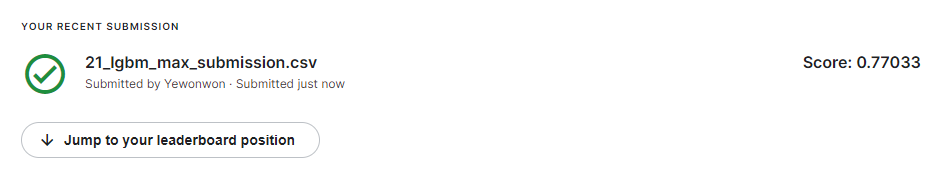

## d. 결론

0 혹은 1 을 맞추는 모델이기 때문에 두 가지 경우의 수로 나누어지는 Decision Tree 분류 모델에 파라메터를 튜닝한 모델의 성능이 좋게 나온 것으로 예상